In [1]:
from PIL import Image
import numpy as np
import cv2
import torch
import torch.nn.functional as F
from UNet.utils.data_loading import BasicDataset
from UNet.utils.utils import plot_img_and_mask
from UNet.unet import UNet

def load_img(img_path: str, binary=False):
    if not binary:
        return cv2.imread(img_path)
    else:
        im = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Binarize
        _ , im = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY)
        return im

class UNet_Predictor(object):
    def __init__(self, weight_path:str,
                        scale = 0.5,
                        threshold=0.5,
                        n_classes=2, 
                        device='cpu') -> None:
        self.device = torch.device(device) if isinstance(device, str) else device
        self.n_classes = n_classes
        # Initialize Model
        
        self.model = UNet(n_channels=3, n_classes=self.n_classes)
        self.model.to(device=device)
        state_dict = torch.load(weight_path, map_location=device)
        self.mask_values = state_dict.pop('mask_values')
        self.model.load_state_dict(state_dict)
        self.scale = scale
        self.threshold = threshold

    def predict(self, img_path: str, to_img=False):
        # Load image
        full_img = Image.open(img_path)

        self.model.eval()
        img = torch.from_numpy(BasicDataset.preprocess(None, 
                                                        full_img, 
                                                        self.scale, 
                                                        is_mask=False))
        img = img.unsqueeze(0)
        img = img.to(device=self.device, dtype=torch.float32)

        # Predict
        with torch.no_grad():
            output = self.model(img).cpu()
            output = F.interpolate(output, 
                                    (full_img.size[1], full_img.size[0]), 
                                    mode='bilinear')
            if self.n_classes > 1:
                mask = output.argmax(dim=1)
            else:
                mask = torch.sigmoid(output) > self.threshold

            mask = mask[0].long().squeeze().numpy()
        if to_img:
            return self.mask_to_image(mask)
        else:
            return mask

    def mask_to_image(self, mask: np.ndarray):
        if isinstance(self.mask_values[0], list):
            out = np.zeros((mask.shape[-2], mask.shape[-1], len(self.mask_values[0])), dtype=np.uint8)
        elif self.mask_values == [0, 1]:
            out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
        else:
            out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

        if mask.ndim == 3:
            mask = np.argmax(mask, axis=0)

        for i, v in enumerate(self.mask_values):
            out[mask == i] = v
        return Image.fromarray(out)


c:\Users\user\anaconda3\envs\yolov5\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
weight_path = './UNet/checkpoints/checkpoint_epoch60.pth'
scale = 0.5
theshold = 0.5
n_classses = 1
predictor = UNet_Predictor(weight_path=weight_path, 
                            scale=scale, 
                            threshold=theshold,
                            n_classes=n_classses)

powder_uncover_0.txt


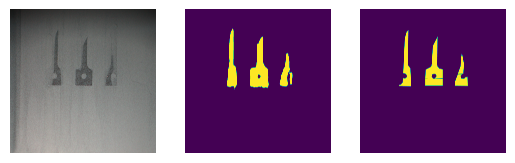

powder_uncover_1.txt


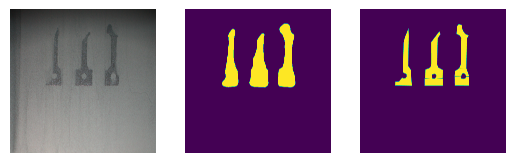

powder_uncover_10.txt


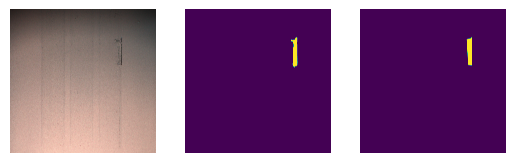

powder_uncover_11.txt


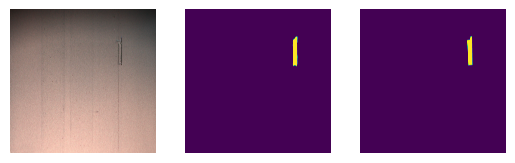

powder_uncover_12.txt


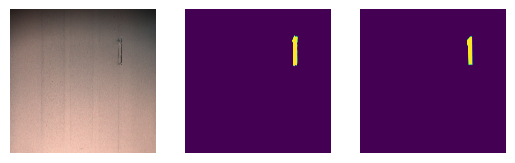

powder_uncover_13.txt


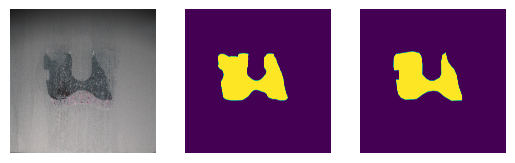

powder_uncover_14.txt


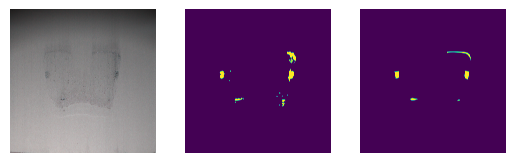

powder_uncover_15.txt


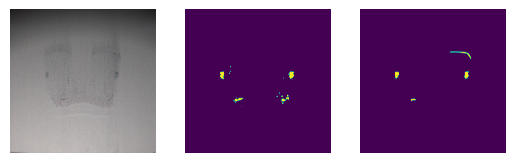

powder_uncover_16.txt


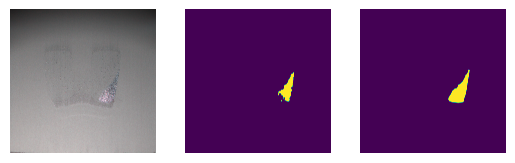

powder_uncover_17.txt


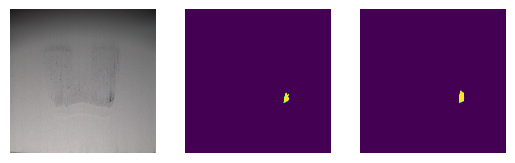

powder_uncover_18.txt


In [4]:
import os
from os.path import join
import matplotlib.pyplot as plt
import cv2
import numpy as np
split = 'Val'

crop_root = './data/unet/{}'.format(split)
img_root = './data/yolov5/{}'.format(split)

predictor.threshold = 0.2

# Read label
label_folder = join(crop_root, 'labels')
label_files = os.listdir(label_folder)[0:]
for f_i, f in enumerate(label_files):
    print(f)
    raw_name = f.split('.')[0]
    img_name = raw_name + '.png'
    with open(join(label_folder, f), 'r') as f:
        lines = f.readlines()

    origin_img_path = join(img_root, 'images', img_name)
    origin_im = load_img(origin_img_path)
    im_h, im_w, _ = origin_im.shape
    origin_predict_mask = np.zeros((im_h, im_w))
    for line in lines:
        # Get information of box in this crop image
        crop_name = line.split(',')[0]
        box_info = line.split(',')[1:]
        box_w, box_h, x1, y1, x2, y2 = [int(c) for c in box_info]

        crop_img_path = join(crop_root, 'images', crop_name)
        crop_mask_path = join(crop_root, 'masks', crop_name)
        origin_size = (box_w, box_h)

        # Predict
        predict_mask = predictor.predict(crop_img_path, to_img=True)

        # ax = plt.subplot(1,3,1)
        # ax.imshow(load_img(crop_img_path))
        # ax.axis(False)

        # ax = plt.subplot(1,3,2)
        # ax.imshow(predict_mask)
        # ax.axis(False)

        # ax = plt.subplot(1,3,3)
        # ax.imshow(load_img(crop_mask_path))
        # ax.axis(False)
        # plt.imshow(predict_mask)
        # print(np.unique(predict_mask))

        predict_mask = np.array(predict_mask)
         
        predict_mask = cv2.resize(predict_mask, origin_size, interpolation=cv2.INTER_NEAREST)
        origin_predict_mask[y1:y2, x1:x2] = predict_mask
    plt.show()
    ax = plt.subplot(1,3,1)
    ax.imshow(origin_im)
    ax.axis(False)

    ax = plt.subplot(1,3,2)
    ax.imshow(origin_predict_mask)
    ax.axis(False)
    
    origin_mask_path = join(img_root, 'masks', img_name)
    origin_mask = load_img(origin_mask_path, binary=True)
    ax = plt.subplot(1,3,3)
    ax.imshow(origin_mask)
    ax.axis(False)
    plt.show()
        # print(origin_size, predict_mask.shape)
        
        # crop_im = load_img(crop_img_path)
        # crop_im = cv2.resize(crop_im, origin_size)


        # ax = plt.subplot(1,3,1)
        # ax.imshow(crop_im)
        # ax.axis(False)

        # ax = plt.subplot(1,3,2)
        # ax.imshow(resized_predict_mask)
        # ax.axis(False)

        # gt_mask = load_img(crop_mask_path)
        # gt_mask = cv2.resize(gt_mask, origin_size, interpolation=cv2.INTER_NEAREST)
        # ax = plt.subplot(1,3,3)
        # ax.imshow(gt_mask)
        # ax.axis(False)
    #     break
    # plt.show()
    if f_i == 10:
        break

In [7]:
os.getcwd()

'd:\\研究所課程\\孫永年影像處理\\homework\\ncku_image_processing\\final_hw'

In [3]:
from UNet.utils.data_loading import BasicDataset
from torch.utils.data import DataLoader
import os

os.chdir('./UNet/')
from UNet.evaluate import evaluate
dir_img = '../data/unet/Val/images/'
dir_mask = '../data/unet/Val/masks/'
img_scale = 0.5
batch_size = 16
val_set = BasicDataset(dir_img, dir_mask, img_scale)

loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

dice_score = evaluate(predictor.model, val_loader, predictor.device, False)
print(dice_score)

Validation round:   0%|          | 0/13 [00:00<?, ?batch/s]c:\Users\user\anaconda3\envs\yolov5\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
                                                                    

tensor(0.8890)


In [9]:
dice_score

tensor(0.8965)

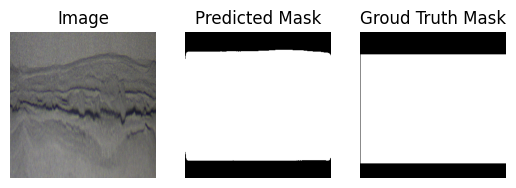

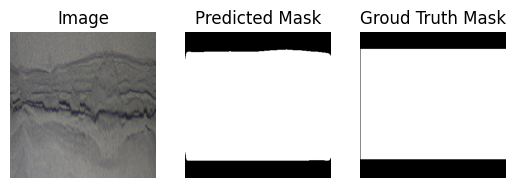

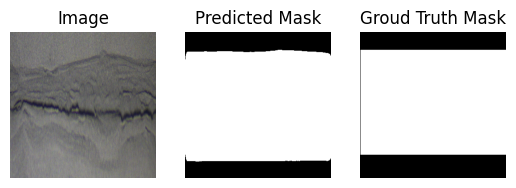

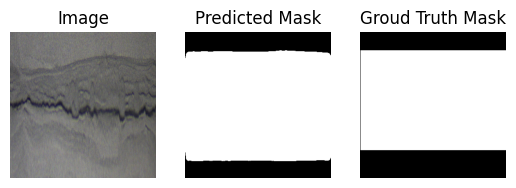

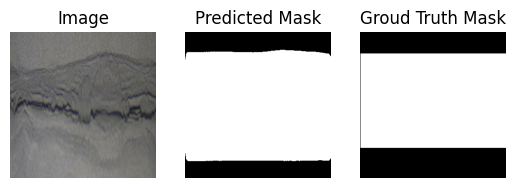

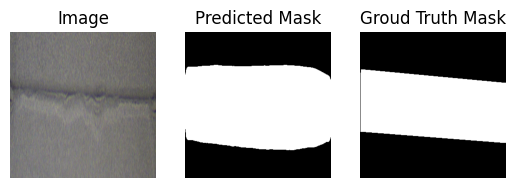

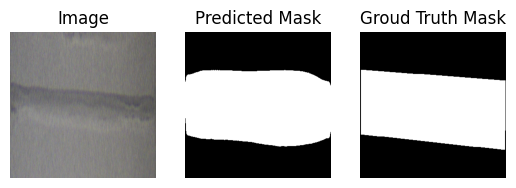

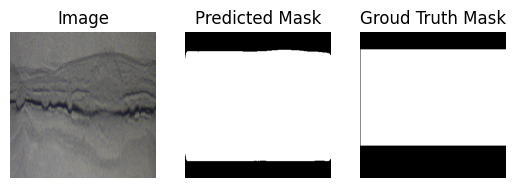

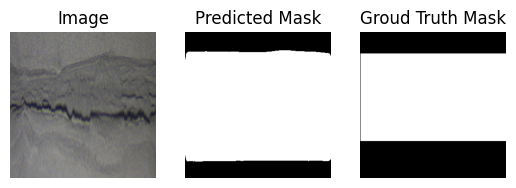

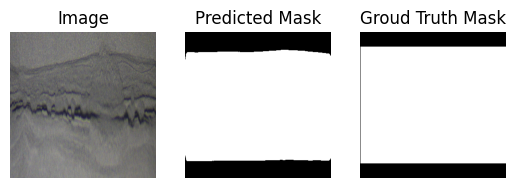

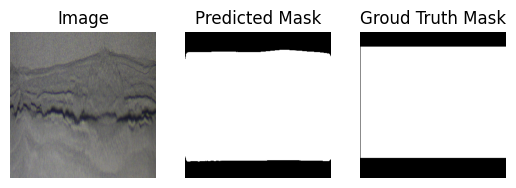

In [15]:
import os
from os.path import join
import matplotlib.pyplot as plt
split = 'Val'

crop_root = './data/unet/{}'.format(split)
img_root = './data/yolov5/{}'.format(split)

# Read label
label_files = os.listdir(join(crop_root, 'labels'))
for f in label_files:
    raw_name = f.split('.')[0]
    img_name = raw_name + '.png'



for i, f in enumerate(imgs):
    img_path = join(img_root, f)
    predict_mask = predictor.predict(img_path)
    predict_mask = predictor.mask_to_image(predict_mask)

    mask_path = join(mask_root, f)
    mask = Image.open(mask_path)

    img = Image.open(img_path)

    ax = plt.subplot(1,3,1)
    ax.axis(False)
    ax.imshow(img)
    ax.set_title('Image')

    ax = plt.subplot(1,3,2)
    ax.axis(False)
    ax.imshow(predict_mask)
    ax.set_title('Predicted Mask')

    ax = plt.subplot(1,3,3)
    ax.axis(False)
    ax.imshow(mask)
    ax.set_title('Groud Truth Mask')

    plt.show()
    # plot_img_and_mask(Image.open(img_path), predict_mask)
    if i == 10:
        break

In [2]:




file_path = './data/unet_resized/Train/images/powder_uncover_0_0.png'
full_img = Image.open(file_path)

scale = 0.5
out_threshold = 0.5
net.eval()
img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale, is_mask=False))
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(img).cpu()
    output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
    if net.n_classes > 1:
        mask = output.argmax(dim=1)
    else:
        mask = torch.sigmoid(output) > out_threshold

    mask = mask[0].long().squeeze().numpy()

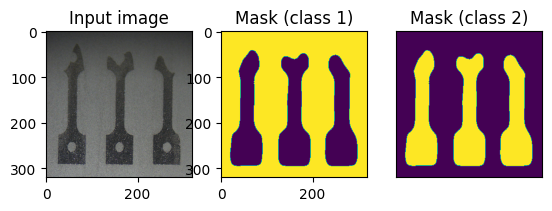

In [4]:

plot_img_and_mask(full_img, mask)

In [5]:
result = mask_to_image(mask, mask_values)

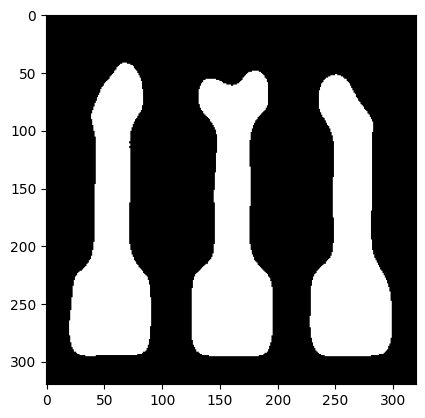

In [6]:
import matplotlib.pyplot as plt

plt.imshow(result)